# DBSCAN

In [2]:
%reload_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append("../")

from pathlib import Path
from collections import defaultdict

import pandas as pd
from scipy.stats import zscore
from tsdr import tsdr
from eval import groundtruth
from meltria import loader
from eval import validation

In [4]:
DATASET_ID = "9n6mf"

In [6]:
from eval.tsdr import load_tsdr_by_chaos

dataset_by_chaos = load_tsdr_by_chaos(
    DATASET_ID, {
        "services": True,
        "containers": True,
        "middlewares": False,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": False,
        "enable_multireducer": False,
    },
    use_manually_selected_metrics=False,
) 

In [7]:
record, data_df_by_metric_type = dataset_by_chaos[("pod-cpu-hog", "carts")][0]
dataset = pd.concat([
    data_df_by_metric_type["containers"][-1],#.iloc[100:180,:],
    data_df_by_metric_type["services"][-1],#.iloc[100:180, :],
], axis=1)
dataset.shape

(180, 186)

In [41]:
from collections.abc import Callable

import numpy as np
import sklearn.cluster
from sklearn.neighbors import kneighbors_graph, sort_graph_by_row_values

def learn_clusters_(
    X: np.ndarray,
    dist_func: Callable,
    min_pts: int = 1,
    algorithm: str = "dbscan",
) -> tuple[np.ndarray, np.ndarray]:
    if len(X) <= 2:
        # avoid "ValueError: Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 3"
        return np.array([]), np.array([])

    match algorithm:
        case "dbscan":
            dist_graph = kneighbors_graph(X=X, n_neighbors=min_pts, mode="distance", metric=dist_func)
            distances = dist_graph.toarray().flatten()
            assert len(distances) != 0, f"distances is empty: {distances}, {X}"
            assert np.isnan(distances).sum() == 0, f"distances has NaN: {distances}, {X}"
            eps = np.nanmax(distances) / 4  # see DBSherlock paper
            if eps == 0.0:
                # avoid "ValueError: eps=0.0 is invalid: must be greater than or equal to 1e-20."
                eps = 1e-20

            print("eps", eps)
            labels = sklearn.cluster.DBSCAN(
                eps=eps,
                min_samples=min_pts,
                metric="precomputed",
            ).fit_predict(dist_graph)
            return labels, dist_graph.toarray()

In [ ]:
from tsdr.clustering.pearsonr import pearsonr_as_dist

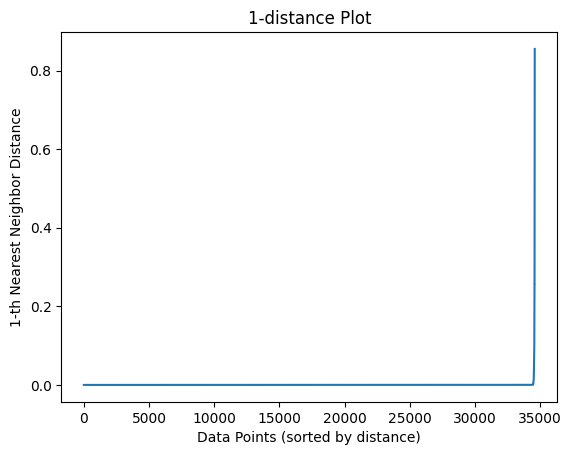

In [46]:
dist_graph = kneighbors_graph(X=dataset.values.T, n_neighbors=1, mode="distance", metric=pearsonr_as_dist)
distances = np.sort(dist_graph.toarray().flatten())

import matplotlib.pyplot as plt

plt.plot(range(len(distances)), distances)
plt.xlabel('Data Points (sorted by distance)')
plt.ylabel(f'{1}-th Nearest Neighbor Distance')
plt.title(f'{1}-distance Plot')
plt.show()

In [43]:
labels, distarrys = learn_clusters_(dataset.values.T, min_pts=1, dist_func=pearsonr_as_dist, algorithm="dbscan")
labels

eps 0.21957665099907137


array([ 0,  1,  1,  2,  2,  2,  1,  3,  4,  2,  4,  1,  0,  4,  2,  4,  5,
        6,  6,  7,  7,  8,  8,  9,  6, 10, 11,  9, 12,  7,  6,  7,  7, 12,
        7, 11, 13, 14, 14, 15, 14, 16,  8, 13, 14, 13, 13, 15, 17, 18, 18,
       19, 19, 18, 20, 21, 22, 18, 22, 22, 19, 23, 24, 25, 25, 26, 27, 27,
       25,  8, 28, 24, 25, 24, 24, 27, 28, 29, 30, 30, 31, 31, 30, 32, 33,
       29, 30, 29, 29, 31, 33, 34, 35, 35, 36, 37, 35, 38,  8, 39, 34, 35,
       34, 34, 36, 39, 40, 41, 41, 42, 42, 43, 43, 44, 41, 45,  8, 46, 44,
       47, 48, 41, 48, 48, 47, 49, 46, 50, 51, 51, 52, 51, 53, 54, 50, 51,
       50, 50, 52, 54, 55, 56, 56, 57, 56, 58, 55, 56, 55, 55, 57, 59, 60,
       61, 61, 62, 62, 63, 63, 61, 64,  8, 65, 66, 67, 61, 67, 67, 63, 68,
       69, 70, 11, 70, 71, 70, 72, 70, 72, 11, 70, 73, 72, 74, 70, 75])